<a href="https://colab.research.google.com/drive/1iuoOgbnief2Dart6YJ6iuTeCEhOhVJW1" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [1]:
!pip install grad-cam
!pip install torch_lr_finder
! git clone https://github.com/ak112/pytorch-main-eva8
!mv pytorch-main-eva8/* .
from utils.utils import *
from models.resnet_cif_custom import *
from main import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=4240ba86e5982fad8244f642d6795478188cb2a7beff33b3f417710df5431489
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'pytorch-main-eva8'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 71 (delta 23), reused 55 (delta 13), pack-reused 0
Unpacking objects: 100% (71/71), 18.26 KiB | 1.30 MiB/s, done.


### Dataloader Arguments & Test/Train Dataloaders

In [2]:
cifar10 = dataset_cifar10(batch_size=512)
trainloader = cifar10.loader(train_flag=True)
testloader = cifar10.loader(train_flag=False)
classes = cifar10.classes

CUDA availability ? True


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


### Model and Params


In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256

### Finding LR(One Cycle policy)

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.11E-02


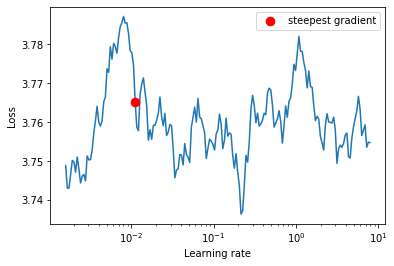

Max LR is 0.21461411978584036


In [11]:
import copy
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

net_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=200,step_mode='exp')
lr_finder.plot()
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

### Model Training

In [12]:
epochs=24
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.95, weight_decay=0.0005, nesterov=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.21,
                                                total_steps=2400,
                                                steps_per_epoch=len(trainloader),
                                                epochs=24,
                                                pct_start=5/epochs,
                                                div_factor=24,
                                                three_phase=False, 
                                                final_div_factor=1,
                                                anneal_strategy='linear',
                                                cycle_momentum=True,
                                                base_momentum=0.85
                                                )
net, history = fit_model(
    net=model, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=trainloader, test_loader=testloader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.008749999999999999)


Batch_id=97 Loss=2.89884 Accuracy=23.46%: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 1.9275, Accuracy: 3289/10000 (32.89%)

EPOCH: 2 (LR: 0.04827404809619238)


Batch_id=97 Loss=1.68846 Accuracy=41.66%: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 1.4827, Accuracy: 4841/10000 (48.41%)

EPOCH: 3 (LR: 0.08779809619238475)


Batch_id=97 Loss=1.42242 Accuracy=51.71%: 100%|██████████| 98/98 [00:12<00:00,  7.55it/s]



Test set: Average loss: 1.2258, Accuracy: 5578/10000 (55.78%)

EPOCH: 4 (LR: 0.12732214428857716)


Batch_id=97 Loss=1.19102 Accuracy=59.23%: 100%|██████████| 98/98 [00:12<00:00,  7.54it/s]



Test set: Average loss: 1.0360, Accuracy: 6354/10000 (63.54%)

EPOCH: 5 (LR: 0.16684619238476953)


Batch_id=97 Loss=1.01584 Accuracy=64.98%: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.8950, Accuracy: 6810/10000 (68.10%)

EPOCH: 6 (LR: 0.20637024048096192)


Batch_id=97 Loss=0.86847 Accuracy=69.98%: 100%|██████████| 98/98 [00:13<00:00,  7.35it/s]



Test set: Average loss: 0.7210, Accuracy: 7562/10000 (75.62%)

EPOCH: 7 (LR: 0.20057302631578947)


Batch_id=97 Loss=0.75078 Accuracy=73.88%: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]



Test set: Average loss: 0.6862, Accuracy: 7638/10000 (76.38%)

EPOCH: 8 (LR: 0.19019276315789474)


Batch_id=97 Loss=0.67532 Accuracy=76.65%: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.6134, Accuracy: 7875/10000 (78.75%)

EPOCH: 9 (LR: 0.1798125)


Batch_id=97 Loss=0.61759 Accuracy=78.58%: 100%|██████████| 98/98 [00:13<00:00,  7.43it/s]



Test set: Average loss: 0.5684, Accuracy: 8078/10000 (80.78%)

EPOCH: 10 (LR: 0.16943223684210526)


Batch_id=97 Loss=0.56682 Accuracy=80.30%: 100%|██████████| 98/98 [00:13<00:00,  7.35it/s]



Test set: Average loss: 0.5814, Accuracy: 7987/10000 (79.87%)

EPOCH: 11 (LR: 0.15905197368421053)


Batch_id=97 Loss=0.53054 Accuracy=81.58%: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 0.4843, Accuracy: 8357/10000 (83.57%)

EPOCH: 12 (LR: 0.14867171052631578)


Batch_id=97 Loss=0.49495 Accuracy=82.94%: 100%|██████████| 98/98 [00:13<00:00,  7.52it/s]



Test set: Average loss: 0.5034, Accuracy: 8269/10000 (82.69%)

EPOCH: 13 (LR: 0.13829144736842106)


Batch_id=97 Loss=0.46705 Accuracy=83.72%: 100%|██████████| 98/98 [00:12<00:00,  7.54it/s]



Test set: Average loss: 0.4576, Accuracy: 8415/10000 (84.15%)

EPOCH: 14 (LR: 0.12791118421052633)


Batch_id=97 Loss=0.43451 Accuracy=84.91%: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.4110, Accuracy: 8572/10000 (85.72%)

EPOCH: 15 (LR: 0.11753092105263158)


Batch_id=97 Loss=0.41502 Accuracy=85.51%: 100%|██████████| 98/98 [00:13<00:00,  7.48it/s]



Test set: Average loss: 0.3807, Accuracy: 8673/10000 (86.73%)

EPOCH: 16 (LR: 0.10715065789473685)


Batch_id=97 Loss=0.38319 Accuracy=86.60%: 100%|██████████| 98/98 [00:12<00:00,  7.55it/s]



Test set: Average loss: 0.3745, Accuracy: 8729/10000 (87.29%)

EPOCH: 17 (LR: 0.09677039473684211)


Batch_id=97 Loss=0.37243 Accuracy=87.06%: 100%|██████████| 98/98 [00:13<00:00,  7.37it/s]



Test set: Average loss: 0.3655, Accuracy: 8761/10000 (87.61%)

EPOCH: 18 (LR: 0.08639013157894739)


Batch_id=97 Loss=0.34353 Accuracy=88.00%: 100%|██████████| 98/98 [00:13<00:00,  7.45it/s]



Test set: Average loss: 0.3534, Accuracy: 8805/10000 (88.05%)

EPOCH: 19 (LR: 0.07600986842105265)


Batch_id=97 Loss=0.32320 Accuracy=88.69%: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.3495, Accuracy: 8826/10000 (88.26%)

EPOCH: 20 (LR: 0.06562960526315789)


Batch_id=97 Loss=0.30604 Accuracy=89.36%: 100%|██████████| 98/98 [00:13<00:00,  7.52it/s]



Test set: Average loss: 0.3790, Accuracy: 8746/10000 (87.46%)

EPOCH: 21 (LR: 0.055249342105263166)


Batch_id=97 Loss=0.28587 Accuracy=89.94%: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]



Test set: Average loss: 0.3133, Accuracy: 8934/10000 (89.34%)

EPOCH: 22 (LR: 0.04486907894736844)


Batch_id=97 Loss=0.26163 Accuracy=90.75%: 100%|██████████| 98/98 [00:13<00:00,  7.44it/s]



Test set: Average loss: 0.3118, Accuracy: 8944/10000 (89.44%)

EPOCH: 23 (LR: 0.03448881578947369)


Batch_id=97 Loss=0.24125 Accuracy=91.49%: 100%|██████████| 98/98 [00:12<00:00,  7.60it/s]



Test set: Average loss: 0.2880, Accuracy: 9029/10000 (90.29%)

EPOCH: 24 (LR: 0.02410855263157896)


Batch_id=97 Loss=0.20843 Accuracy=92.64%: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.2682, Accuracy: 9125/10000 (91.25%)



### Plotting Loss Curves

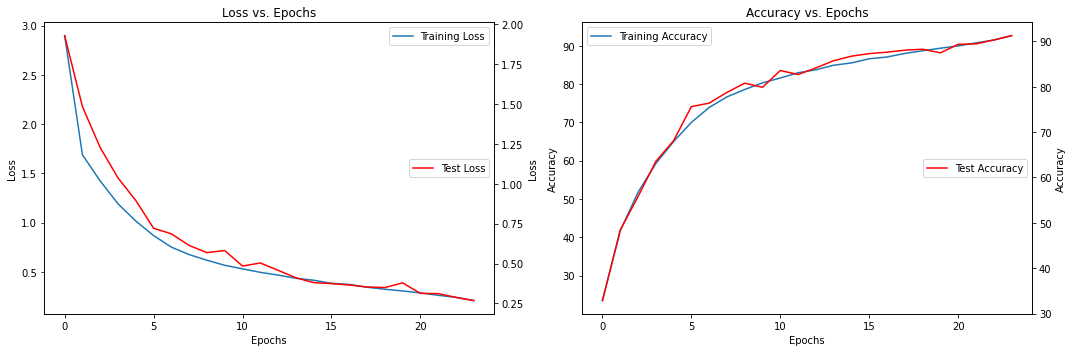

In [13]:
plot_loss_accuracy_graph_OneCLR(*history[0:4])